In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from model import Model
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
# current best: horizontal 0.5, rotation 15, jitter 0.2 0.2 0.2 0.1, blur 5 5 0.1 0.5
# performance on 20 epochs:
# Test Loss: 0.02
# Accuracy: 99.77%
# Precision: 99.77%
# Recall: 99.77%
# F1: 99.77%
# Accuracy for glioma: 99.33%
# Accuracy for meningioma: 100.00%
# Accuracy for notumor: 100.00%
# Accuracy for pituitary: 99.67%

transform = transforms.Compose([
    # transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5), # use with custom model
    # transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), #
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), #
    # transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dir = 'Training'
test_dir = 'Testing'

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

classes = train_dataset.classes
print(f"Labels:{classes}")

Labels:['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
# model = models.resnet18(weights=True)
# model.fc = nn.Linear(model.fc.in_features, 4)

model = models.densenet121(weights=True)
model.classifier = nn.Linear(model.classifier.in_features, 4)

# model = Model()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)
print(torch.cuda.is_available())

C:\Users\Kris Prasad\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..1.8556864].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.454815].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5071026].


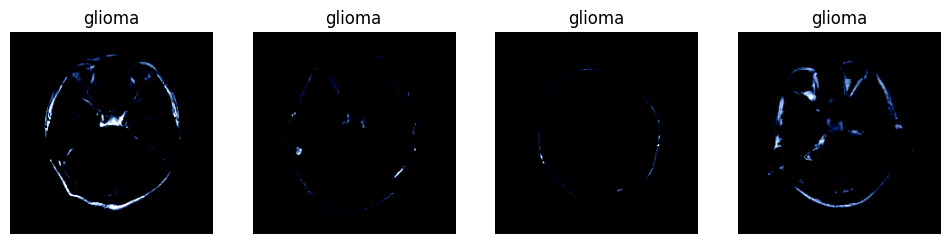

In [4]:
cur_images = 0
num_images = 4
fig = plt.figure(figsize=(12, 12))

for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)      
      
      for i in range(inputs.size(0)):
        if cur_images < num_images:
          cur_images += 1
          ax = fig.add_subplot(1, 4, cur_images)
          ax.imshow(inputs[i].cpu().permute(1, 2, 0))
          ax.set_title(f"{classes[labels[i]]}")
          ax.axis("off")

In [5]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=0.001)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [6]:
def get_val_loss(model, test_loader, loss_fn):
  model.eval()
  val_loss = 0.0

  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      val_loss += loss.item()
  
  val_loss /= len(test_loader)
  return val_loss

In [7]:
def train(model, train_loader, loss_fn, optimizer, scheduler, num_epochs=20, patience=3, validate_every=3):
    scaler = GradScaler()
    # no_improvement = 0
    # best_loss = np.inf
    
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # loss.backward()
            # optimizer.step()
            
            running_loss += loss.item()

        if (epoch + 1) % validate_every == 0:
            val_loss = get_val_loss(model, test_loader, loss_fn)
            scheduler.step(val_loss)

            print(f"Learning Rate: {scheduler.get_last_lr()}")

            print(f"Epoch {epoch+1} / {num_epochs}, Loss: {running_loss / len(train_loader)}")

            # if running_loss / len(train_loader) < best_loss:
            #     best_loss = running_loss / len(train_loader)
            #     no_improvement = 0
            # else:
            #     no_improvement += 1
            
            # if no_improvement >= patience:
            #     print("Stopping Early")
            #     break
        else:
            print(f"Epoch {epoch+1} / {num_epochs}, Loss: {running_loss / len(train_loader)}")

train(model, train_loader, loss_fn, optimizer, scheduler)

Epoch 1 / 20, Loss: 0.21215254979926115
Epoch 2 / 20, Loss: 0.09701710585608829
Learning Rate: [0.001]
Epoch 3 / 20, Loss: 0.07526532541856419
Epoch 4 / 20, Loss: 0.12834287738666855
Epoch 5 / 20, Loss: 0.1077772132927479
Learning Rate: [0.001]
Epoch 6 / 20, Loss: 0.05487591338307498
Epoch 7 / 20, Loss: 0.060092131331479746
Epoch 8 / 20, Loss: 0.0523085402501695
Learning Rate: [0.001]
Epoch 9 / 20, Loss: 0.06447782779539098
Epoch 10 / 20, Loss: 0.044068832387471335
Epoch 11 / 20, Loss: 0.03759141763745073
Learning Rate: [0.001]
Epoch 12 / 20, Loss: 0.03368271044429454
Epoch 13 / 20, Loss: 0.05528999382224163
Epoch 14 / 20, Loss: 0.05308415659562835
Learning Rate: [0.0005]
Epoch 15 / 20, Loss: 0.03539549809094914
Epoch 16 / 20, Loss: 0.01884513552295429
Epoch 17 / 20, Loss: 0.010440528059804905
Learning Rate: [0.0005]
Epoch 18 / 20, Loss: 0.007047308827412195
Epoch 19 / 20, Loss: 0.013052827777476284
Epoch 20 / 20, Loss: 0.028086786787936142


Test Loss: 0.02
Accuracy: 99.77%
Precision: 99.77%
Recall: 99.77%
F1: 99.77%
Accuracy for glioma: 99.33%
Accuracy for meningioma: 100.00%
Accuracy for notumor: 100.00%
Accuracy for pituitary: 99.67%


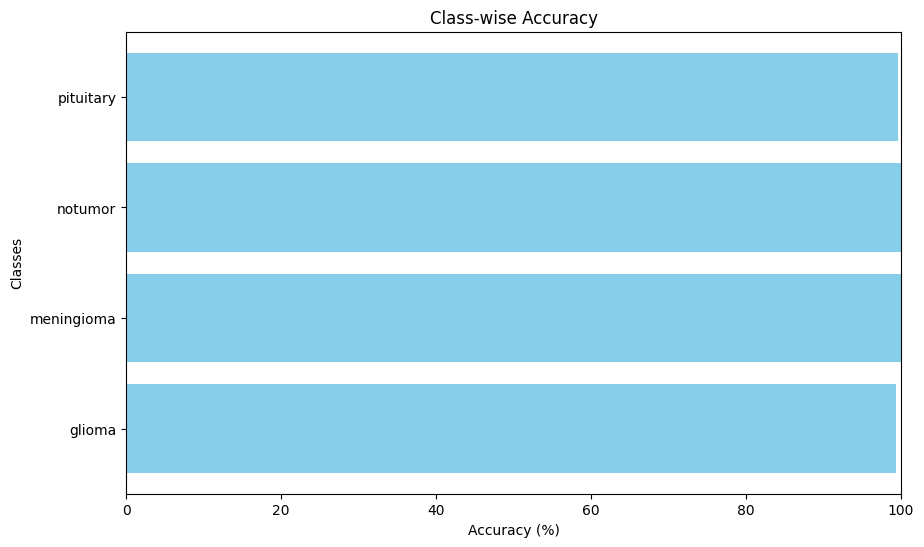

In [8]:
def evaluate(model, test_loader, loss_fn):
  model.eval()

  running_loss = 0
  all_labels = []
  all_predictions = []

  class_correct = [0] * len(classes)
  class_total = [0] * len(classes)

  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      running_loss += loss.item()

      _, predictions = torch.max(outputs.data, 1)

      all_labels.extend(labels.cpu().numpy())
      all_predictions.extend(predictions.cpu().numpy())

      for i in range(len(labels)):
        label = labels[i]
        class_total[label] += 1
        if predictions[i] == label:
          class_correct[label] += 1

  class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(len(classes))]
  
  test_loss = running_loss / len(test_loader)
  accuracy = accuracy_score(all_labels, all_predictions) * 100
  precision = precision_score(all_labels, all_predictions, average='weighted') * 100
  recall = recall_score(all_labels, all_predictions, average='weighted') * 100
  f1 = f1_score(all_labels, all_predictions, average='weighted') * 100

  print(f"Test Loss: {test_loss:.2f}")
  print(f"Accuracy: {accuracy:.2f}%")
  print(f"Precision: {precision:.2f}%")
  print(f"Recall: {recall:.2f}%")
  print(f"F1: {f1:.2f}%")
  for i in range(len(classes)):
    print(f"Accuracy for {classes[i]}: {class_accuracy[i]:.2f}%")

  plt.figure(figsize=(10, 6))
  plt.barh(classes, class_accuracy, color='skyblue')
  plt.xlabel('Accuracy (%)')
  plt.ylabel('Classes')
  plt.title('Class-wise Accuracy')
  plt.xlim(0, 100)
  plt.show()

evaluate(model, test_loader, loss_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2565577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..1.2805231].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8033988].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].


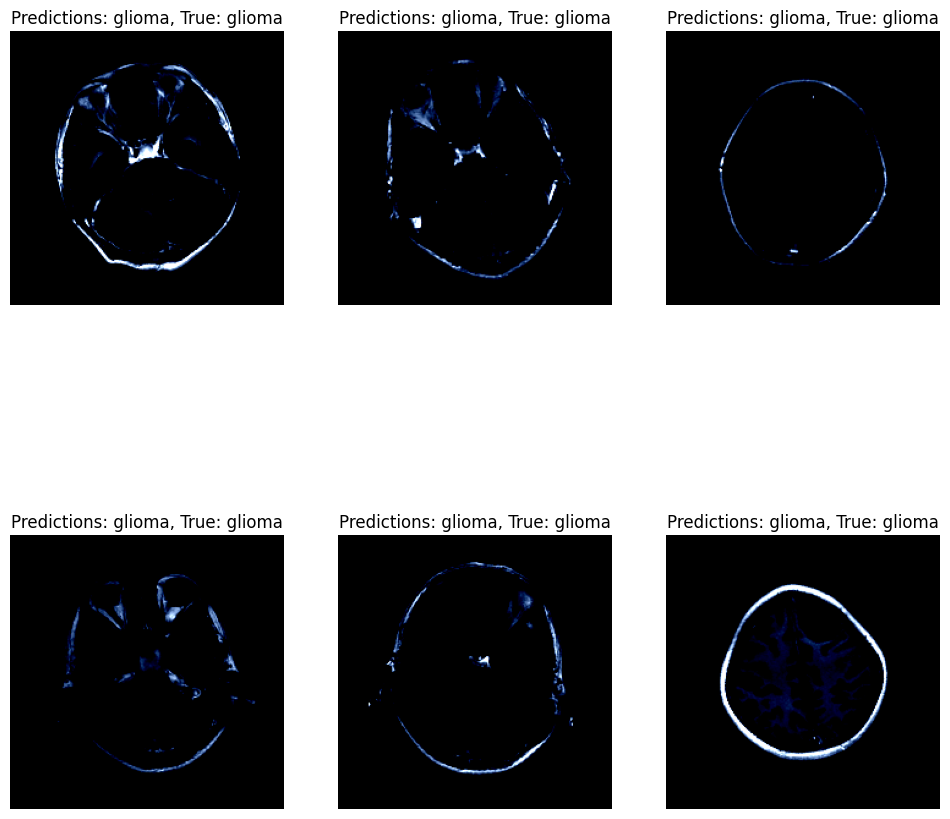

In [9]:
def show_predictions(model, test_loader, classes, num_images=6):
  model.eval()

  cur_images = 0
  fig = plt.figure(figsize=(12, 12))

  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predictions = torch.max(outputs.data, 1)
      
      for i in range(inputs.size(0)):
        cur_images += 1
        ax = fig.add_subplot(2, 3, cur_images)
        ax.imshow(inputs[i].cpu().permute(1, 2, 0))
        ax.set_title(f"Predictions: {classes[predictions[i]]}, True: {classes[labels[i]]}")
        ax.axis("off")
        if cur_images == num_images:
          return

show_predictions(model, test_loader, classes)